In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from sklearn.metrics import davies_bouldin_score

Рассматриваем датасет с отзывами пользователей на различные категории мест. \
Опираясь на то, в каких категориях человек оставлял высокие оценки хотим кластеризовать пользователей на несколько групп по интересам \
(на основе этого далее можно будет понимать каким людям советовать события из той или иной категории)

In [2]:
data = pd.read_csv('google_review_ratings.csv', sep=',')
data

,User,gender,age,churches,resorts,beaches,parks,theatres,museums,malls,...,dance clubs,swimming pools,gyms,bakeries,beauty & spas,cafes,view points,monuments,gardens,Unnamed: 27
0,User 1,male,31,0.0,0.00,3.63,3.65,5.00,2.92,5.00,...,0.59,0.50,0.00,0.50,0.0,0.00,0.00,0.00,0.00,NaN
1,User 2,male,31,0.0,0.00,3.63,3.65,5.00,2.92,5.00,...,0.59,0.50,0.00,0.50,0.0,0.00,0.00,0.00,0.00,NaN
2,User 3,male,54,0.0,0.00,3.63,3.63,5.00,2.92,5.00,...,0.59,0.50,0.00,0.50,0.0,0.00,0.00,0.00,0.00,NaN
3,User 4,female,30,0.0,0.50,3.63,3.63,5.00,2.92,5.00,...,0.59,0.50,0.00,0.50,0.0,0.00,0.00,0.00,0.00,NaN
4,User 5,male,28,0.0,0.00,3.63,3.63,5.00,2.92,5.00,...,0.59,0.50,0.00,0.50,0.0,0.00,0.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5451,User 981,female,76,5.0,5.00,5.00,1.24,1.25,4.77,4.14,...,0.87,0.88,0.90,1.08,5.0,0.51,0.51,0.52,0.65,NaN
5452,User 2752,male,74,5.0,2.64,2.59,2.39,2.37,1.66,5.00,...,0.84,1.02,1.01,1.06,5.0,0.93,5.00,2.67,2.66,NaN
5453,User 2753,male,69,5.0,2.66,2.59,2.39,1.76,1.67,1.48,...,0.83,1.02,1.01,1.03,5.0,0.92,5.00,3.75,3.68,NaN
5454,User 4633,female,61,5.0,5.00,1.32,1.31,1.33,4.21,4.21,...,0.81,0.82,0.84,1.04,5.0,0.51,0.52,0.54,0.73,NaN


В основу взят датасет гугл (https://www.kaggle.com/datasets/wirachleelakiatiwong/travel-review-rating-dataset), \
нам будут интересны только некоторые места, которые рассмотрим подробнее:
1. церкви
2. курорты
3. пляжи
4. парки
5. театры
6. музеи
7. торговые центры
8. зоопарки
9. рестораны
10. пабы и бары
11. арт галлереи
12. танцевальные клубы
13. бассейны
14. пекарни
15. спа салоны
16. кофейни
17. смотровые площадки
18. сады

Также нам известна информация о пользователях, которые оставили отзывы. Мы знаем из возраст и пол,\
поэтому в начале посмотрим как оценки в категориях завиcят от этих параметров.

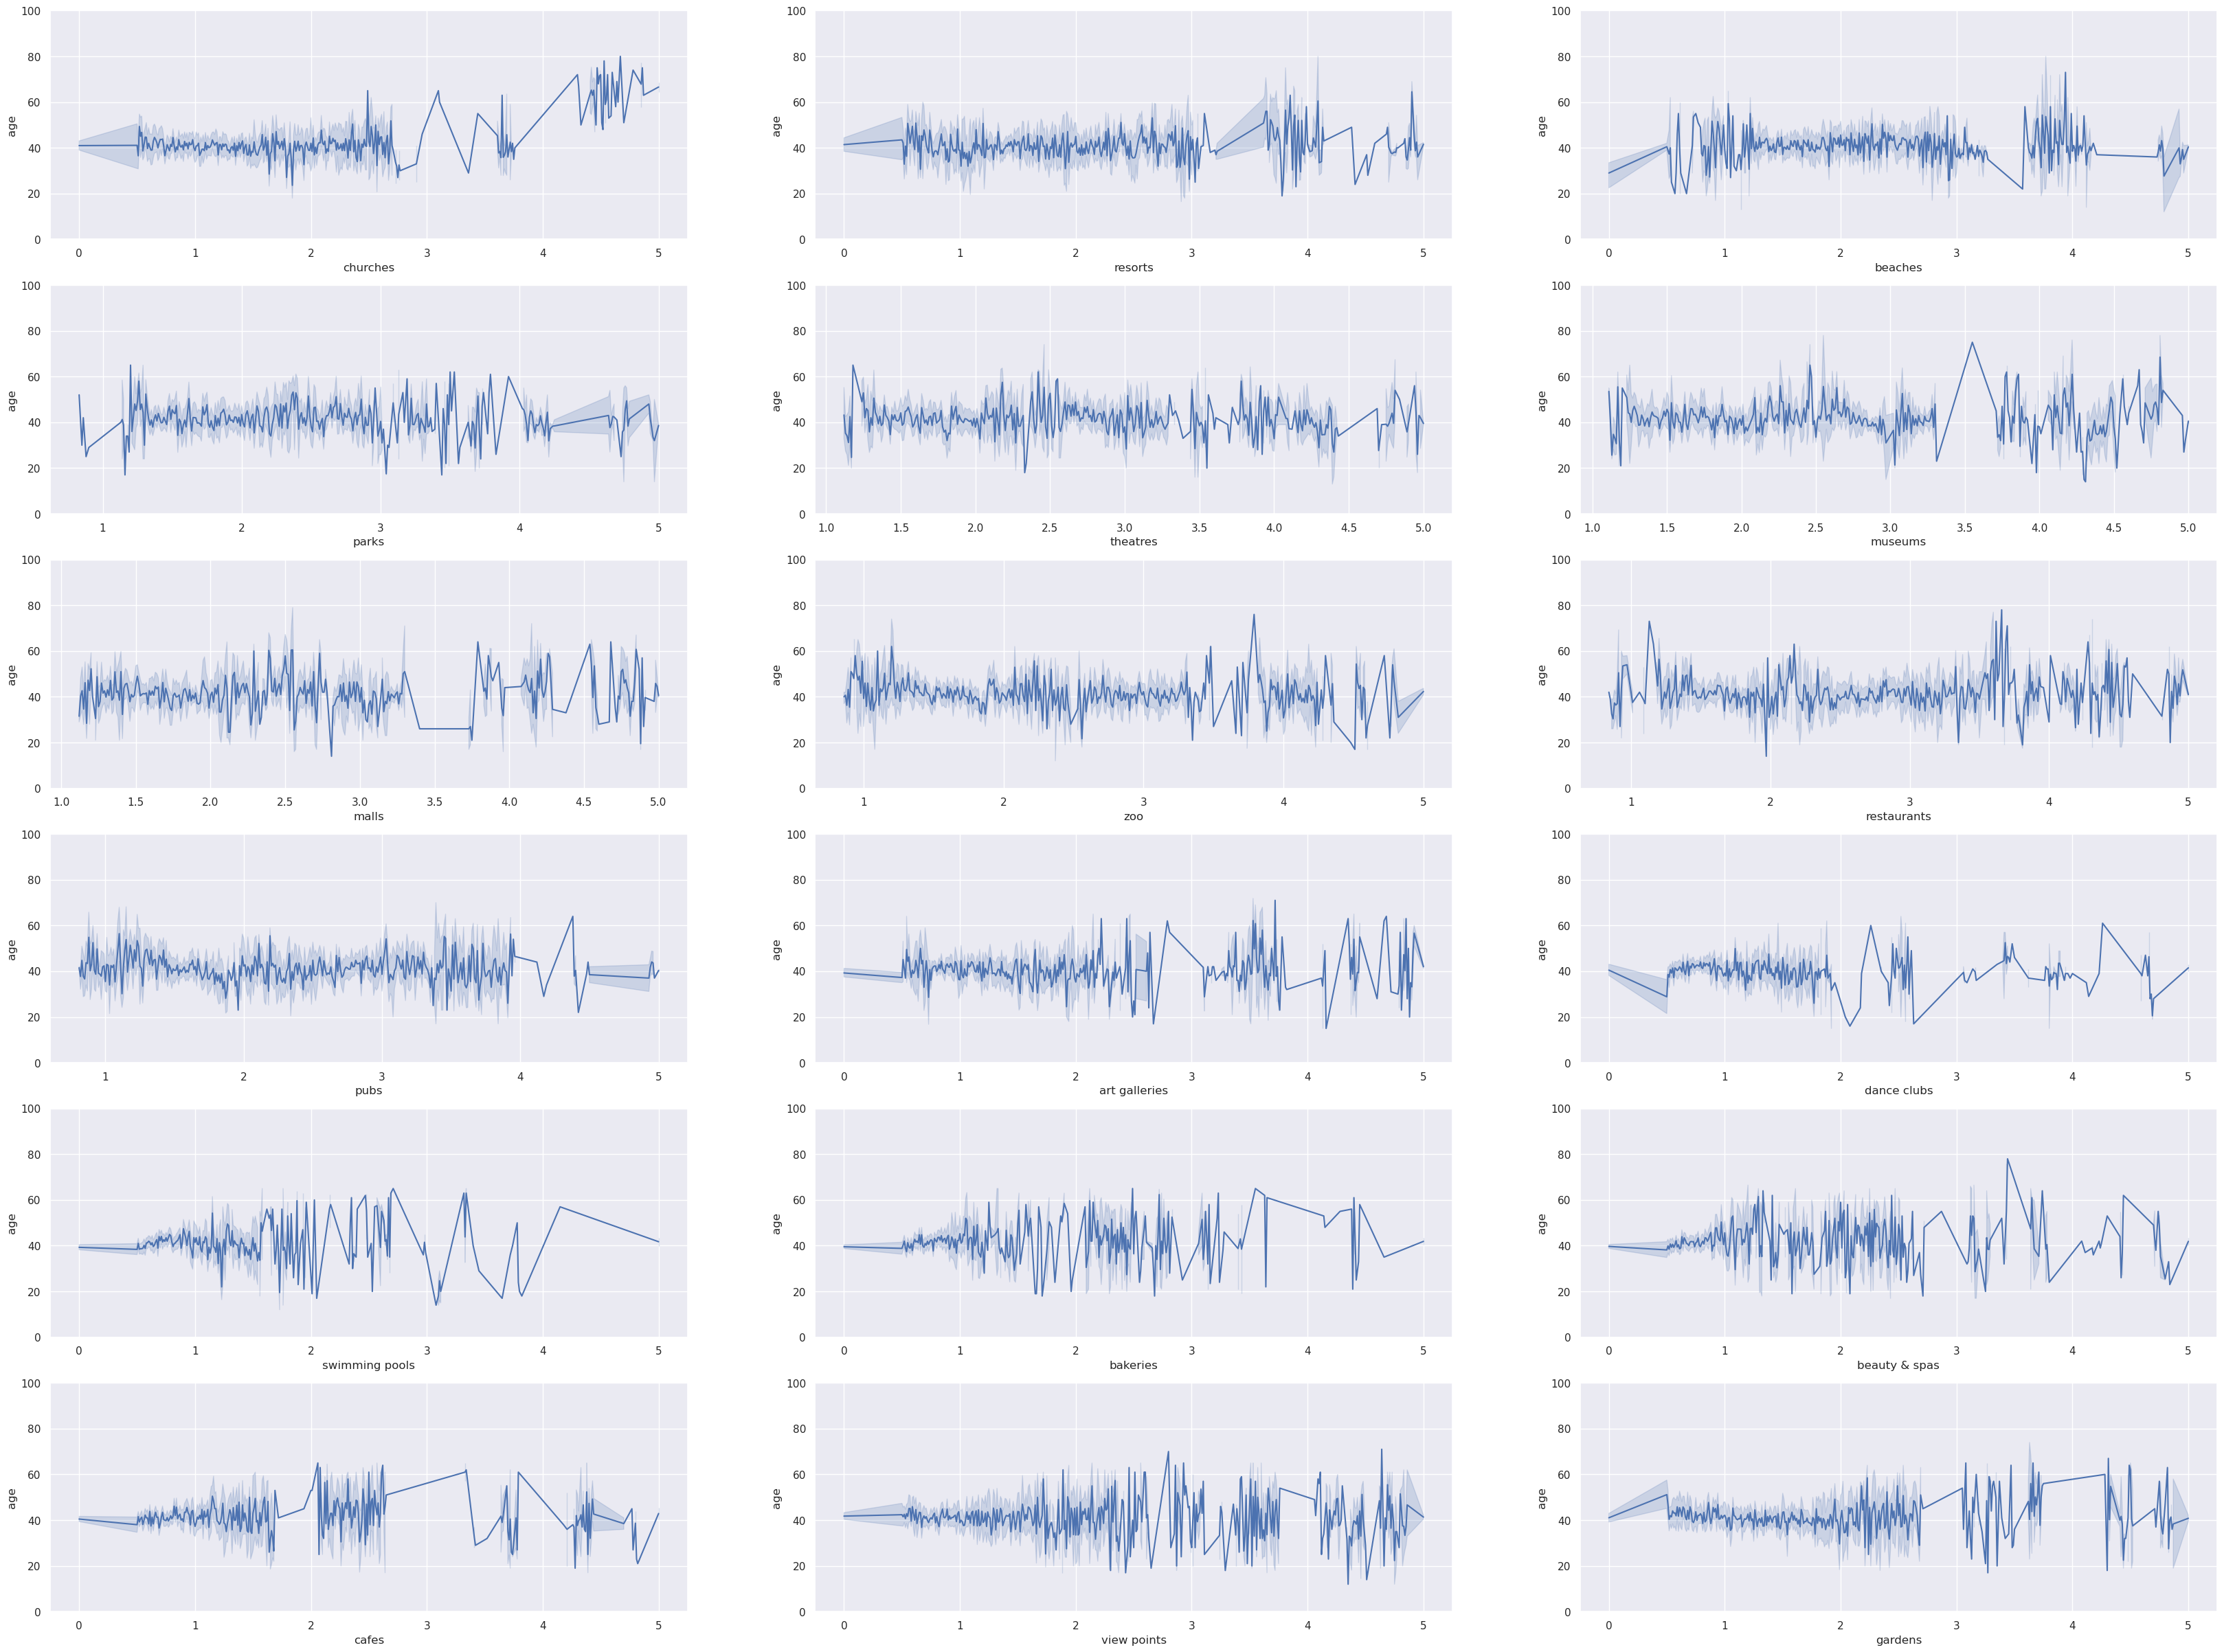

In [3]:
categories = ['churches', 'resorts', 'beaches', 'parks', 'theatres', 'museums', 'malls', 'zoo', 
              'restaurants', 'pubs', 'art galleries', 'dance clubs', 'swimming pools', 'bakeries',
              'beauty & spas', 'cafes', 'view points', 'gardens']

sns.set(rc={'figure.figsize':(40.7,30.27)})
k = 1
for category in categories:
    plt.subplot(6, 3, k)
    plt.ylim(0, 100)
    sns.lineplot(data=data, x=category, y='age')
    k = k + 1

Заметим, что:
1. Люди, которые чаще ставят высокие оценки церквям старше 55 лет
2. Люди, которые ставят высокие оценки пляжам и курортам в возрасте от 30 до 50 лет
3. Люди, которые ставят больше 4.5 баллов бассейнам в возрасте от 40 до 50 лет
4. Люди, которые ставят больше 4.5 баллов кофейням в возрасте до 45 лет
5. Люди почтенного возраста ходят и оценивают чаще всего церкви, музеи и рестораны и салоны красоты

Таким образом, зная возраст человека можем определить что ему понравится с бОльшей вероятностью.

В собранном датасете примерно одинаковое количество отзывов от мужчин и женщин:

In [4]:
categories = ['resorts', 'beaches', 'parks', 'theatres', 'museums', 'malls', 'zoo', 
              'restaurants', 'pubs', 'art galleries', 'dance clubs', 'swimming pools', 'bakeries',
              'beauty & spas', 'cafes', 'view points', 'gardens']

data_notnull = data[data['churches'] != 0]
for category in categories:
    data_notnull = data_notnull[data_notnull[category] != 0]

<Axes: xlabel='gender', ylabel='count'>

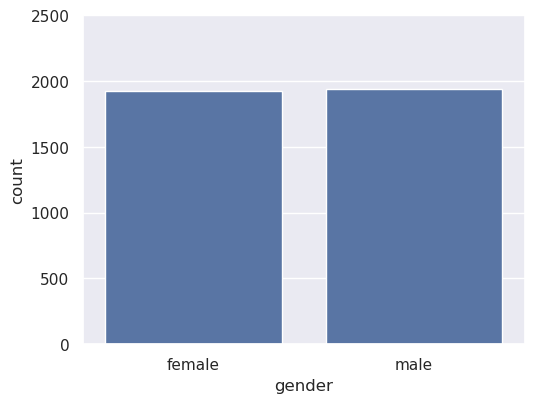

In [5]:
sns.set(rc={'figure.figsize':(5.7,4.27)})
plt.ylim(0, 2500)
sns.countplot(x='gender', data=data_notnull)

Посмотрим, на средние значения отзывов в различных категориях, \
чтобы пронять какие места оставили у большинства пользователей хорошее впечатление, а какие не очень.

(удалили все строчки, в которых есть неоцененные места, чтобы среднее значение отзывов было только из проставленных оценок)

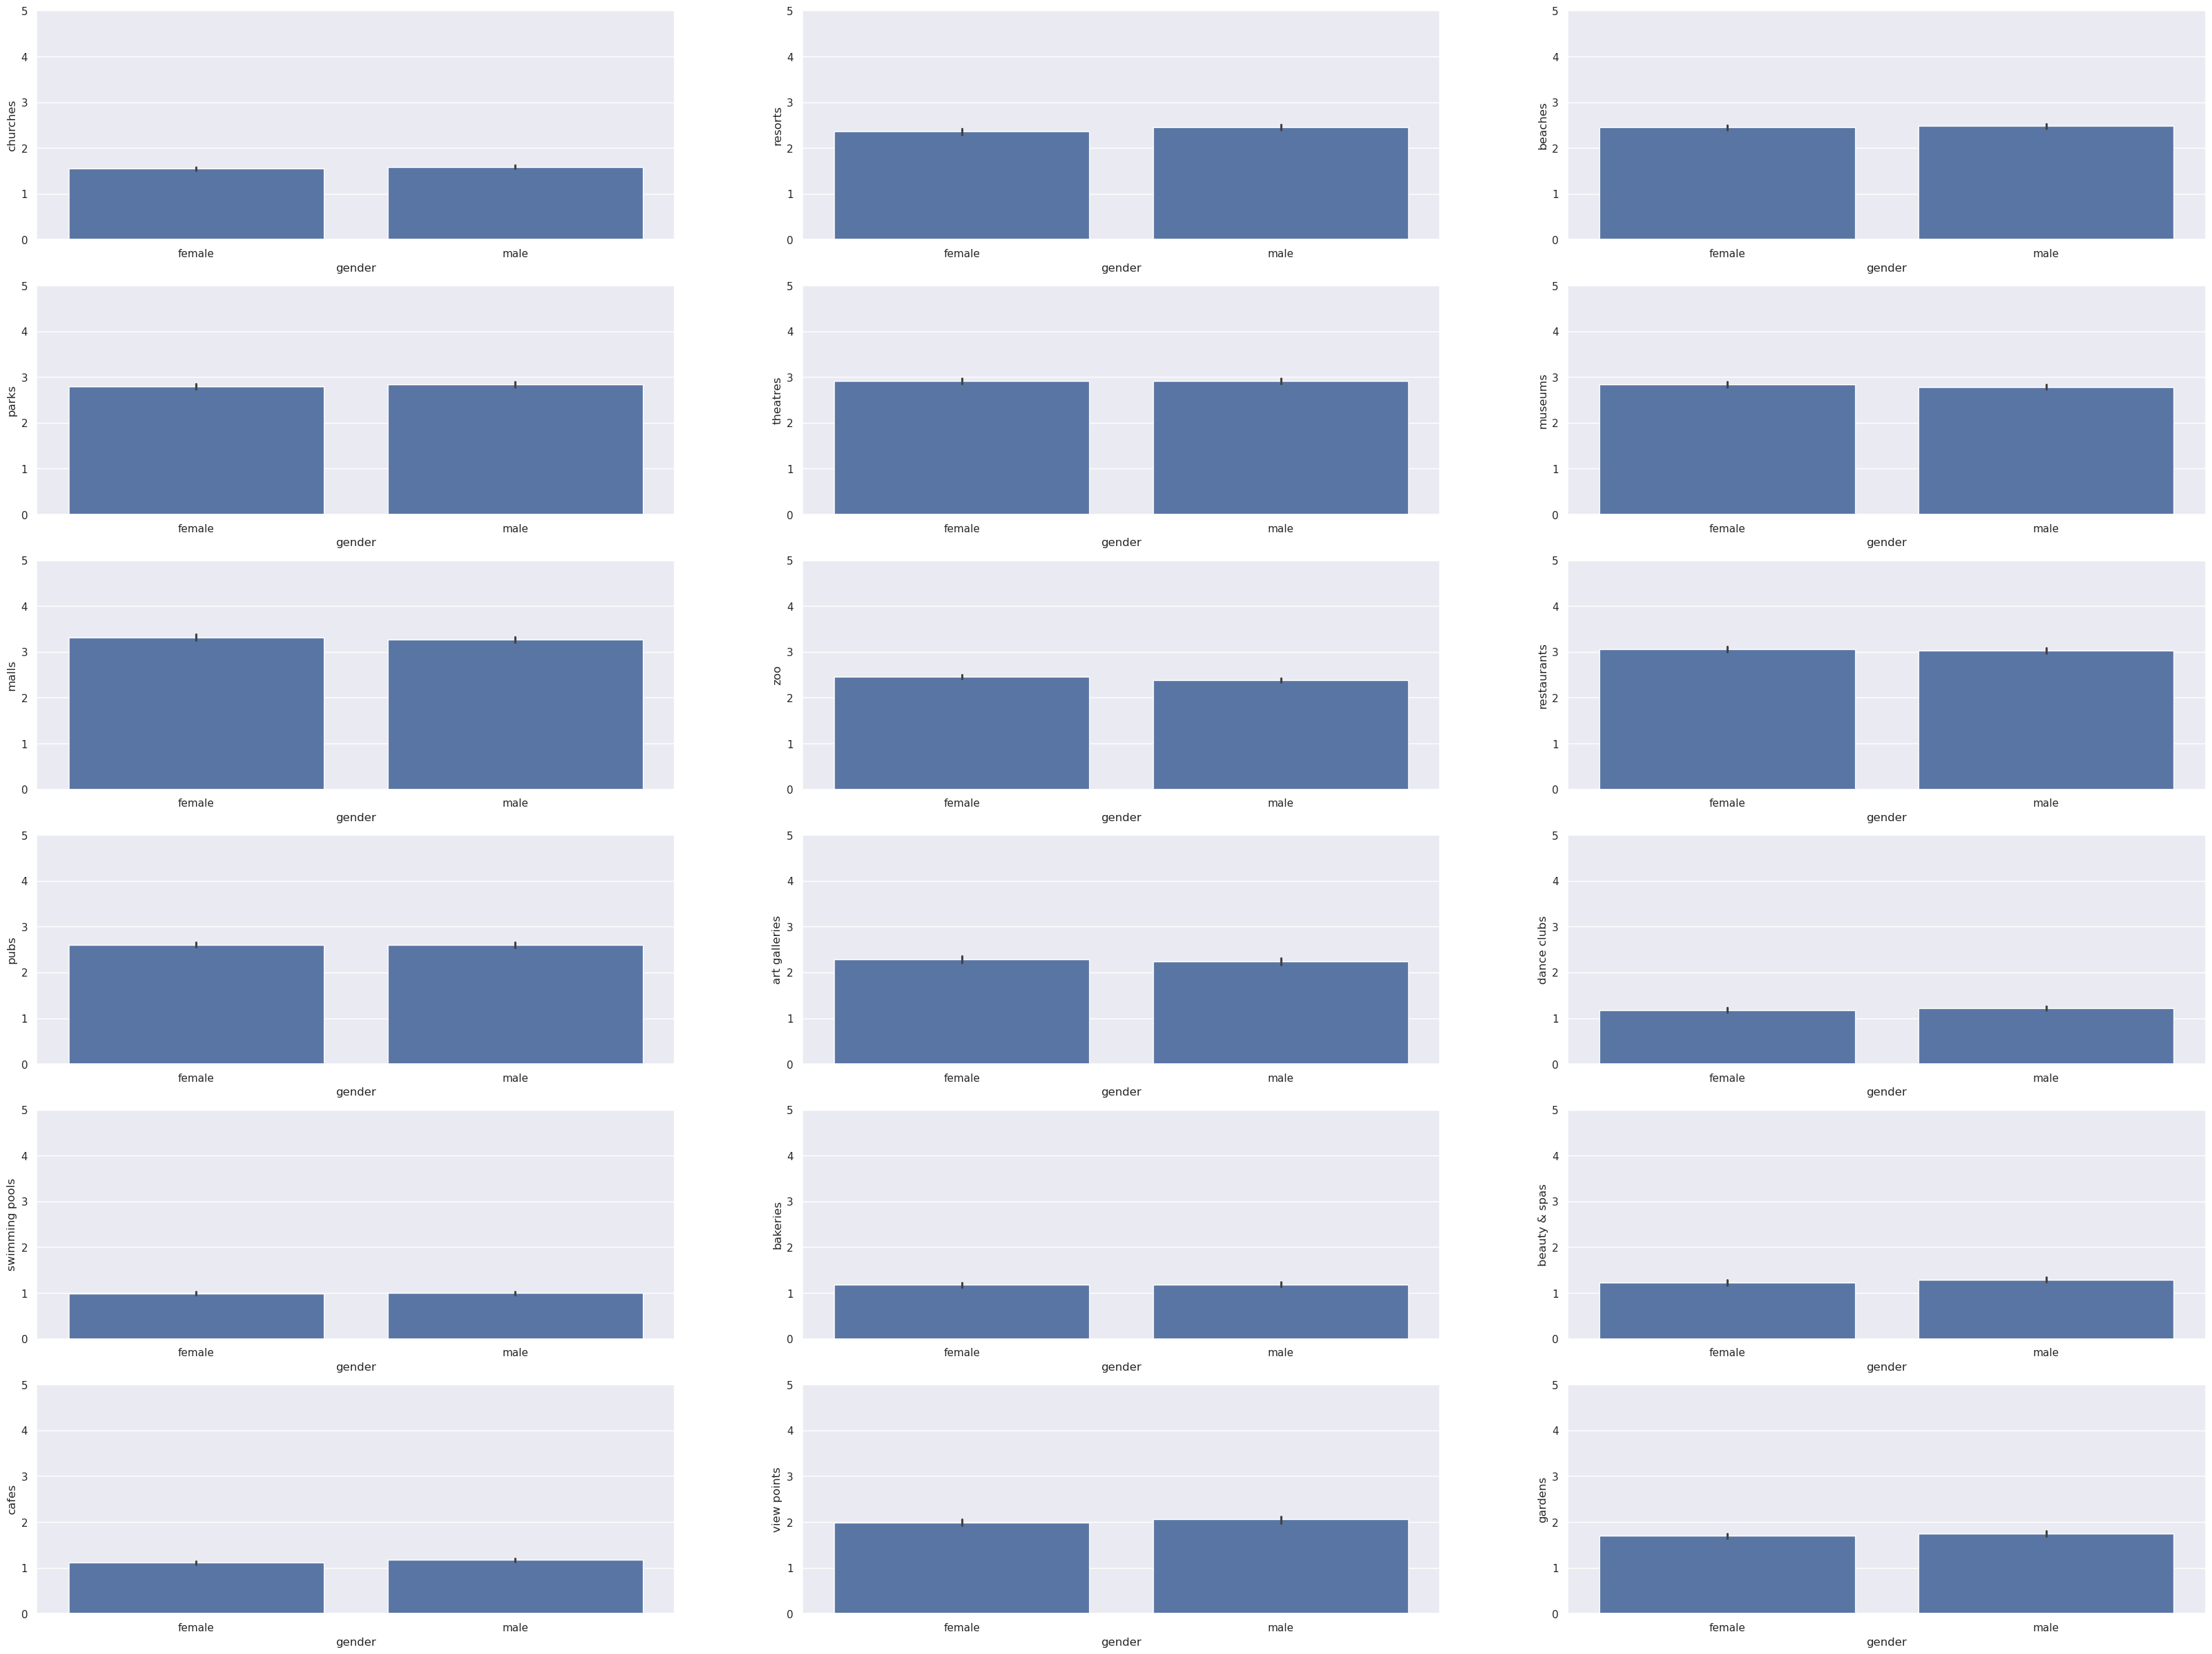

In [6]:
categories = ['churches', 'resorts', 'beaches', 'parks', 'theatres', 'museums', 'malls', 'zoo', 
              'restaurants', 'pubs', 'art galleries', 'dance clubs', 'swimming pools', 'bakeries',
              'beauty & spas', 'cafes', 'view points', 'gardens']


sns.set(rc={'figure.figsize':(40.7,30.27)})

k = 1
for category in categories:
    plt.subplot(6, 3, k)
    plt.ylim(0, 5)
    sns.barplot(x=data_notnull["gender"], y=category, data=data_notnull, estimator=np.mean)
    k = k + 1

из этих таблиц можем сделать вывод, что в среднем очень плохие отзывы получают бассейны, \
а максимально хорошие оценки в основном у торговых центров и ресторанов. \
Из этого делаем вывод, что всем людям актуальны рестораны и торговые центры, а бассейны не оправдывают ожидания. \
Эти категории далее рассматривать не будем.

## Обучение моделей

Мы можем расширить те категории, которые есть у нас сейчас до более общих, например:

поделим людей на тех, кто
- любят отдых на свежем воздухе 'resorts & beaches & parks'
- любят культурно отдыхать 'theatres & museums & art galleries'
- любят перекусить 'cafes & bakeries'
- любят духовный отдых 'churches'
- любят отдых с детьми 'zoo'
- любят уходовые процедуры 'beauty & spas'

Таким образом, зная общую категорию, учитывая возраст и пол мы сможем составить необходимый портрет пользователя.

In [7]:
df = pd.DataFrame()
df['resorts & beaches & parks'] = data[['resorts', 'beaches', 'parks']].mean(axis=1)
df['theatres & museums & art galleries'] = data[['theatres', 'museums', 'art galleries']].mean(axis=1)
df['cafes & bakeries'] = data[['cafes', 'bakeries']].mean(axis=1)
df['churches'] = data['churches']
df['zoo'] = data['zoo']
df['beauty & spas'] = data['beauty & spas']
df

,resorts & beaches & parks,theatres & museums & art galleries,cafes & bakeries,churches,zoo,beauty & spas
0,2.426667,3.220000,0.250,0.0,2.35,0.0
1,2.426667,3.220000,0.250,0.0,2.64,0.0
2,2.420000,3.220000,0.250,0.0,2.64,0.0
3,2.586667,3.220000,0.250,0.0,2.35,0.0
4,2.420000,3.220000,0.250,0.0,2.64,0.0
...,...,...,...,...,...,...
5451,3.746667,3.673333,0.795,5.0,3.79,5.0
5452,2.540000,1.616667,0.995,5.0,1.20,5.0
5453,2.546667,1.416667,0.975,5.0,1.21,5.0
5454,2.543333,2.116667,0.775,5.0,5.00,5.0


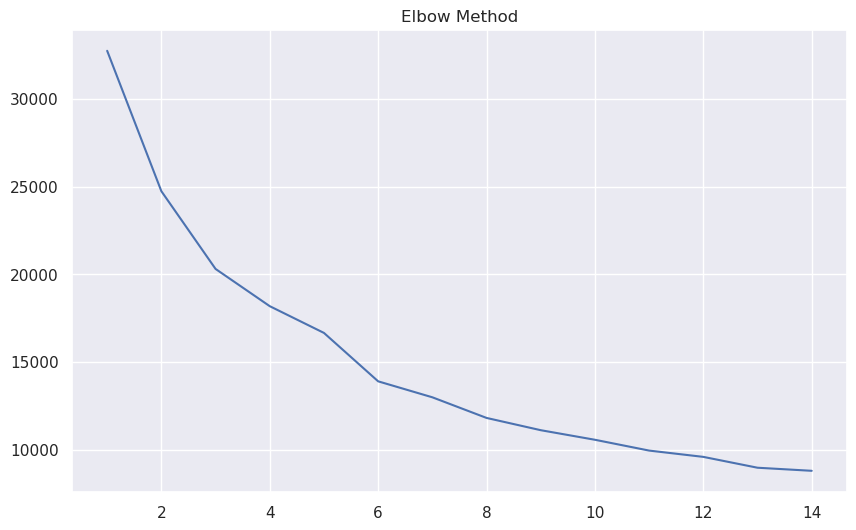

In [8]:
features = ['resorts & beaches & parks', 'theatres & museums & art galleries',  'cafes & bakeries', 'churches', 'zoo', 'beauty & spas']
X = StandardScaler().fit_transform(df[features])
distan = []

def dist(X, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distan.append(kmeans.inertia_)

for n in range(1, 15):
    dist(X, n)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), distan)
plt.title('Elbow Method')
plt.show()

попробуем разделить этих людей на 3 и 7 кластеров\

Поделив на 3 кластера видим приятные картинки и можем проинтерпретировать полученную информацию, \
деление на 7 класстеров показывает лучший dbi, поэтому им также воспользуемся

## модель KMeans, N_CLUSTERS = 3

In [10]:
N_CLUSTERS = 3

model = KMeans(n_clusters=N_CLUSTERS)
labels = model.fit_predict(X)

df['cluster'] = labels
cluster_means = df.groupby('cluster')[features].mean()
print(cluster_means)
dbi = davies_bouldin_score(X, labels)
print(dbi)

         resorts & beaches & parks  theatres & museums & art galleries  \
cluster                                                                  
0                         1.828084                            2.457031   
1                         3.322291                            3.264338   
2                         2.548446                            2.122541   

         cafes & bakeries  churches       zoo  beauty & spas  
cluster                                                       
0                0.678906  1.058379  3.193316       0.613267  
1                0.670486  1.415516  2.332250       0.625392  
2                2.062070  2.311832  1.617995       2.423880  
1.4612362214712078



Полученные группы можно проинтерпретировать как
- Люди, которые любят отдых на свежем воздухе и культурный отдых
- Люди, которые любят зоопарки
- Люди, которые любят кафе, церкви и спа

(тут основываемся также на том, что мы уже знаем средние значения в категориях)

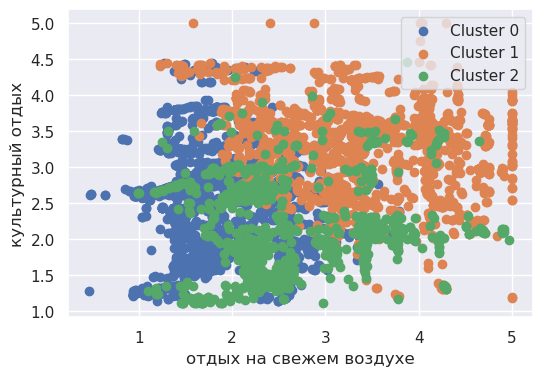

In [11]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['resorts & beaches & parks'], df[df['cluster'] == cluster]['theatres & museums & art galleries'], label=f'Cluster {cluster}')
plt.xlabel('отдых на свежем воздухе')
plt.ylabel('культурный отдых')
plt.legend()
plt.show()

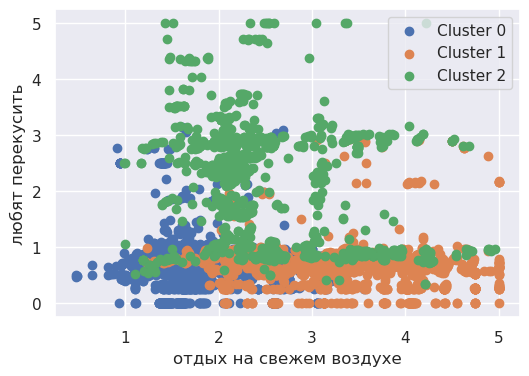

In [12]:
plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['resorts & beaches & parks'], df[df['cluster'] == cluster]['cafes & bakeries'], label=f'Cluster {cluster}')
plt.xlabel('отдых на свежем воздухе')
plt.ylabel('любят перекусить')
plt.legend()
plt.show()

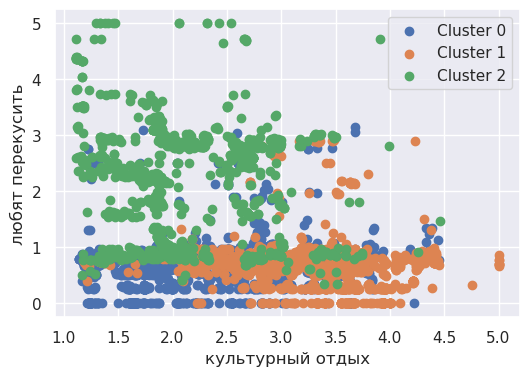

In [13]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['theatres & museums & art galleries'], df[df['cluster'] == cluster]['cafes & bakeries'], label=f'Cluster {cluster}')
plt.xlabel('культурный отдых')
plt.ylabel('любят перекусить')
plt.legend()
plt.show()

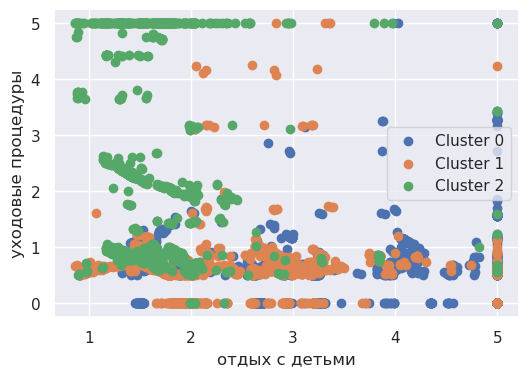

In [14]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['zoo'], df[df['cluster'] == cluster]['beauty & spas'], label=f'Cluster {cluster}')
plt.xlabel('отдых с детьми')
plt.ylabel('уходовые процедуры')
plt.legend()
plt.show()

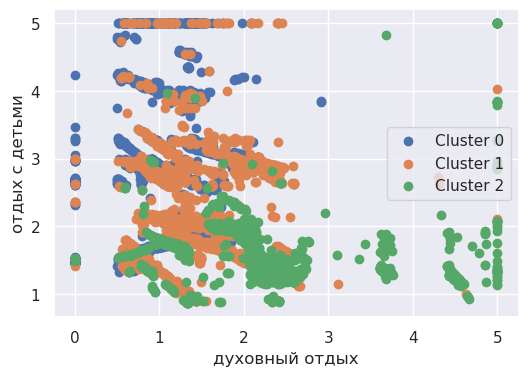

In [15]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['churches'], df[df['cluster'] == cluster]['zoo'], label=f'Cluster {cluster}')
plt.xlabel('духовный отдых')
plt.ylabel('отдых с детьми')
plt.legend()
plt.show()

## модель KMeans, N_CLUSTERS = 7

In [23]:
N_CLUSTERS = 7

model = KMeans(n_clusters=N_CLUSTERS)
labels = model.fit_predict(X)

df['cluster'] = labels
cluster_means = df.groupby('cluster')[features].mean()
print(cluster_means)
dbi = davies_bouldin_score(X, labels)
print(dbi)

         resorts & beaches & parks  theatres & museums & art galleries  \
cluster                                                                  
0                         1.844070                            3.016103   
1                         3.615301                            3.142710   
2                         2.334446                            2.152210   
3                         1.994583                            2.362772   
4                         2.180658                            1.971783   
5                         3.065944                            2.135069   
6                         2.817309                            2.439268   

         cafes & bakeries  churches       zoo  beauty & spas  
cluster                                                       
0                0.712370  1.027103  1.950942       0.662913  
1                0.649570  1.463529  2.396583       0.600264  
2                2.576669  1.903370  1.659859       1.284577  
3                0

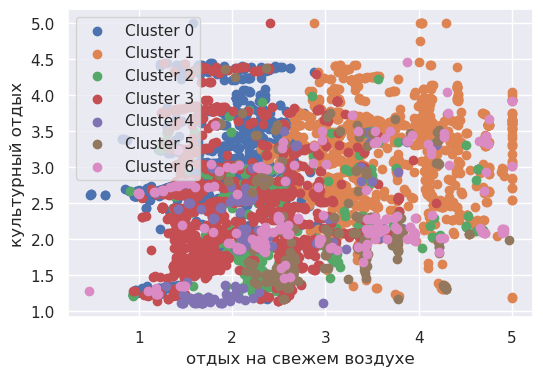

In [24]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['resorts & beaches & parks'], df[df['cluster'] == cluster]['theatres & museums & art galleries'], label=f'Cluster {cluster}')
plt.xlabel('отдых на свежем воздухе')
plt.ylabel('культурный отдых')
plt.legend()
plt.show()

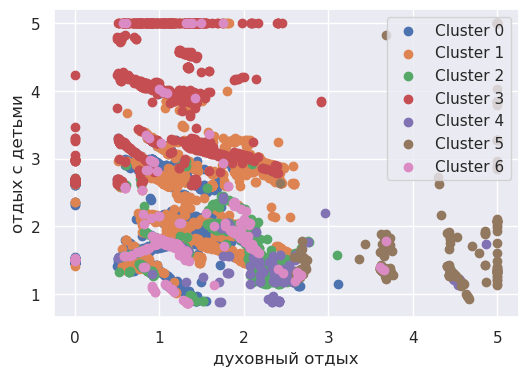

In [25]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['churches'], df[df['cluster'] == cluster]['zoo'], label=f'Cluster {cluster}')
plt.xlabel('духовный отдых')
plt.ylabel('отдых с детьми')
plt.legend()
plt.show()

## модель DBSCAN

In [31]:
model = DBSCAN(eps=0.6, min_samples=70)
labels = model.fit_predict(X)

df['DBSCAN'] = labels
cluster_means = df.groupby('DBSCAN')[features].mean()
print(cluster_means)

mask = labels != -1
X_filtered = X[mask]
y_filtered = labels[mask]
dbi = davies_bouldin_score(X_filtered, y_filtered)
print(dbi)

        resorts & beaches & parks  theatres & museums & art galleries  \
DBSCAN                                                                  
-1                       2.601786                            2.666851   
 0                       3.919867                            3.542107   
 1                       1.646422                            1.755675   
 2                       1.664528                            2.844406   
 3                       2.687049                            3.564098   
 4                       2.990600                            2.897112   
 5                       2.580159                            2.640222   

        cafes & bakeries  churches       zoo  beauty & spas  
DBSCAN                                                       
-1              1.070806  1.469822  2.551456       1.131239  
 0              0.197120  1.246800  1.856640       0.024240  
 1              0.342220  1.458621  3.191810       0.273190  
 2              0.772937  1.0860

In [32]:
model = DBSCAN(eps=0.2, min_samples=20)
labels = model.fit_predict(X)

df['DBSCAN'] = labels
cluster_means = df.groupby('DBSCAN')[features].mean()
print(cluster_means)


mask = labels != -1
X_filtered = X[mask]
y_filtered = labels[mask]
dbi = davies_bouldin_score(X_filtered, y_filtered)
print(dbi)

        resorts & beaches & parks  theatres & museums & art galleries  \
DBSCAN                                                                  
-1                       2.605276                            2.711585   
 0                       0.999643                            2.622857   
 1                       1.454259                            1.679630   
 2                       1.641528                            1.734861   
 3                       1.665000                            1.716500   
 4                       1.724677                            1.634355   
 5                       1.678615                            2.849282   
 6                       1.272851                            2.688070   
 7                       2.577374                            2.620606   
 8                       3.251930                            3.269123   
 9                       3.265517                            2.980805   
 10                      2.268974                  

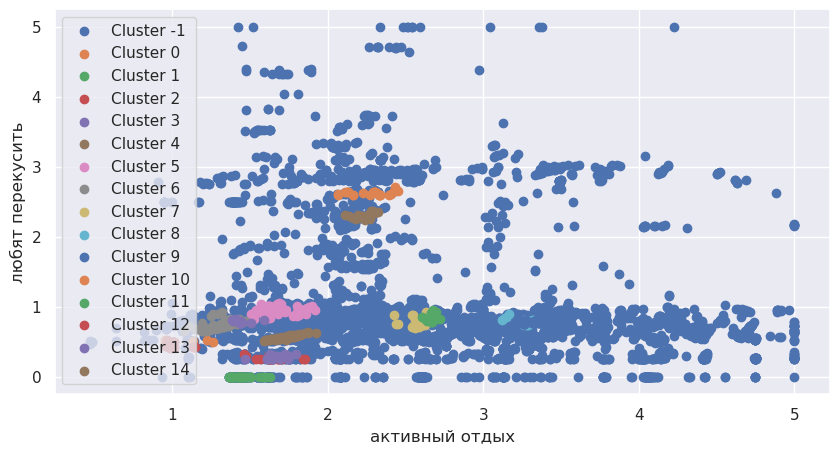

In [33]:
plt.figure(figsize=(10, 5))
for cluster in np.unique(labels):
    plt.scatter(df[df['DBSCAN'] == cluster]['resorts & beaches & parks'], df[df['DBSCAN'] == cluster]['cafes & bakeries'], label=f'Cluster {cluster}')
plt.xlabel('активный отдых')
plt.ylabel('любят перекусить')
plt.legend()
plt.show()

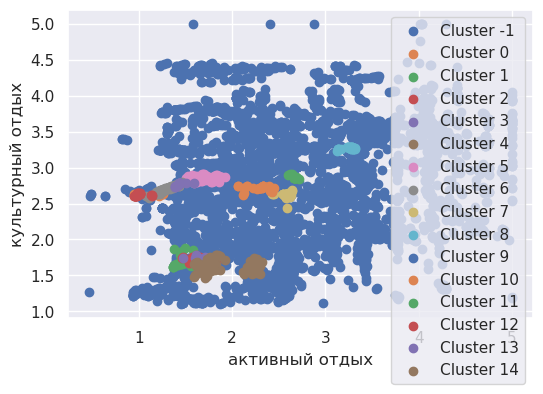

In [34]:
plt.figure(figsize=(6, 4))
for cluster in np.unique(labels):
    plt.scatter(df[df['DBSCAN'] == cluster]['resorts & beaches & parks'], df[df['DBSCAN'] == cluster]['theatres & museums & art galleries'], label=f'Cluster {cluster}')
plt.xlabel('активный отдых')
plt.ylabel('культурный отдых')
plt.legend()
plt.show()

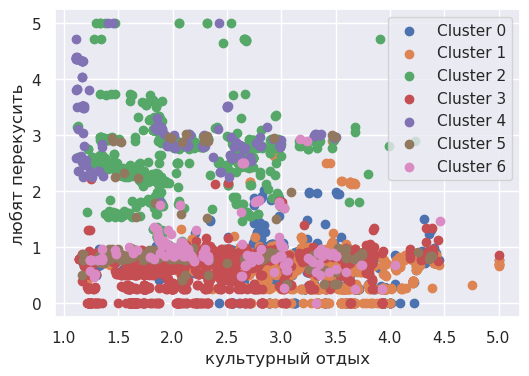

In [36]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['theatres & museums & art galleries'], df[df['cluster'] == cluster]['cafes & bakeries'], label=f'Cluster {cluster}')
plt.xlabel('культурный отдых')
plt.ylabel('любят перекусить')
plt.legend()
plt.show()

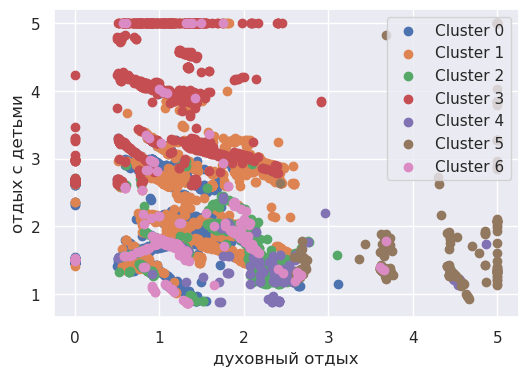

In [37]:
sns.set(rc={'figure.figsize':(40.7,30.27)})

plt.figure(figsize=(6, 4))
for cluster in range(0, N_CLUSTERS):
    plt.scatter(df[df['cluster'] == cluster]['churches'], df[df['cluster'] == cluster]['zoo'], label=f'Cluster {cluster}')
plt.xlabel('духовный отдых')
plt.ylabel('отдых с детьми')
plt.legend()
plt.show()